# Task B: K-Means Clustering on Wine Dataset

This notebook performs K-Means clustering on the Wine dataset from the UCI Machine Learning Repository.

## Objectives:
1. Apply K-Means clustering with various values of K
2. Focus on K=3 to match the three wine classes in the dataset
3. Compare clustering results with actual wine class labels (1, 2, 3)
4. Analyze the chemical composition patterns that distinguish wine clusters

### Import Required Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.decomposition import PCA

%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

### Load and Explore the Wine Dataset

In [4]:
# Load the wine dataset
wine_df = pd.read_csv('data/wine.csv')

# Display basic information
print("Dataset shape:", wine_df.shape)
print("\nColumn names:")
print(wine_df.columns.tolist())
print("\nFirst 5 rows:")
wine_df.head()

Dataset shape: (178, 14)

Column names:
['Wine', 'Alcohol', 'Malic.acid', 'Ash', 'Acl', 'Mg', 'Phenols', 'Flavanoids', 'Nonflavanoid.phenols', 'Proanth', 'Color.int', 'Hue', 'OD', 'Proline']

First 5 rows:


,Wine,Alcohol,Malic.acid,Ash,Acl,Mg,Phenols,Flavanoids,Nonflavanoid.phenols,Proanth,Color.int,Hue,OD,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [5]:
# Check data types and missing values
print("Data types:")
print(wine_df.dtypes)
print("\nMissing values:")
print(wine_df.isnull().sum().sum())
print("\nBasic statistics:")
wine_df.describe()

Data types:
Wine                      int64
Alcohol                 float64
Malic.acid              float64
Ash                     float64
Acl                     float64
Mg                        int64
Phenols                 float64
Flavanoids              float64
Nonflavanoid.phenols    float64
Proanth                 float64
Color.int               float64
Hue                     float64
OD                      float64
Proline                   int64
dtype: object

Missing values:
0

Basic statistics:


,Wine,Alcohol,Malic.acid,Ash,Acl,Mg,Phenols,Flavanoids,Nonflavanoid.phenols,Proanth,Color.int,Hue,OD,Proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,1.938202,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.775035,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,1.000000,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,1.000000,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,2.000000,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,3.000000,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,3.000000,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


First column: Wine
Unique values: [1 2 3]
Value counts:
Wine
1    59
2    71
3    48
Name: count, dtype: int64


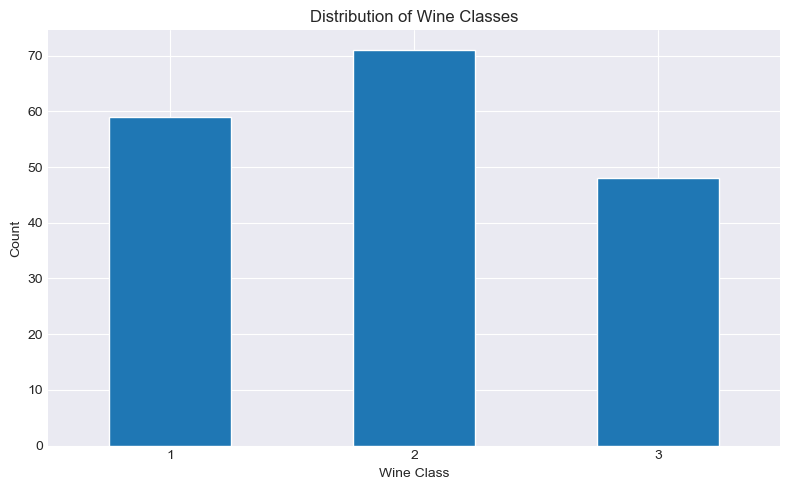

In [6]:
# Identify the class column (usually the first column in wine dataset)
# Check unique values in the first column
first_col = wine_df.columns[0]
print(f"First column: {first_col}")
print(f"Unique values: {wine_df[first_col].unique()}")
print(f"Value counts:\n{wine_df[first_col].value_counts().sort_index()}")

# Assuming the first column is the class label
class_column = first_col

# Visualize class distribution
plt.figure(figsize=(8, 5))
wine_df[class_column].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Wine Classes')
plt.xlabel('Wine Class')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### Data Preprocessing

In [7]:
# Separate features and labels
X = wine_df.drop(class_column, axis=1).values
y_true = wine_df[class_column].values

# Get feature names
feature_names = wine_df.drop(class_column, axis=1).columns.tolist()

print("Feature matrix shape:", X.shape)
print("Number of features:", len(feature_names))
print("\nFeatures used for clustering:")
for i, feature in enumerate(feature_names, 1):
    print(f"{i}. {feature}")

Feature matrix shape: (178, 13)
Number of features: 13

Features used for clustering:
1. Alcohol
2. Malic.acid
3. Ash
4. Acl
5. Mg
6. Phenols
7. Flavanoids
8. Nonflavanoid.phenols
9. Proanth
10. Color.int
11. Hue
12. OD
13. Proline


In [8]:
# Standardize the features (important for K-Means)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create a DataFrame for scaled features
scaled_df = pd.DataFrame(X_scaled, columns=feature_names)

print("Original data statistics:")
print(pd.DataFrame(X, columns=feature_names).describe().loc[['mean', 'std']].round(2))
print("\nScaled data statistics:")
print(scaled_df.describe().loc[['mean', 'std']].round(2))

Original data statistics:
      Alcohol  Malic.acid   Ash    Acl     Mg  Phenols  Flavanoids  \
mean    13.00        2.34  2.37  19.49  99.74     2.30        2.03   
std      0.81        1.12  0.27   3.34  14.28     0.63        1.00   

      Nonflavanoid.phenols  Proanth  Color.int   Hue    OD  Proline  
mean                  0.36     1.59       5.06  0.96  2.61   746.89  
std                   0.12     0.57       2.32  0.23  0.71   314.91  

Scaled data statistics:
      Alcohol  Malic.acid  Ash  Acl   Mg  Phenols  Flavanoids  \
mean     -0.0        -0.0 -0.0 -0.0 -0.0      0.0        -0.0   
std       1.0         1.0  1.0  1.0  1.0      1.0         1.0   

      Nonflavanoid.phenols  Proanth  Color.int  Hue   OD  Proline  
mean                   0.0     -0.0        0.0  0.0  0.0     -0.0  
std                    1.0      1.0        1.0  1.0  1.0      1.0  


### Determine Optimal Number of Clusters

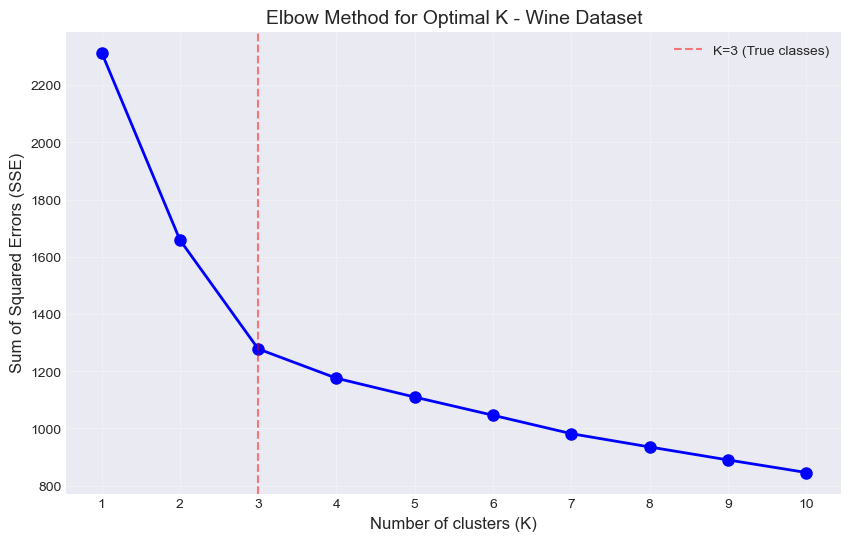

In [9]:
# Elbow method
sse = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=300, random_state=42)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(K_range, sse, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of clusters (K)', fontsize=12)
plt.ylabel('Sum of Squared Errors (SSE)', fontsize=12)
plt.title('Elbow Method for Optimal K - Wine Dataset', fontsize=14)
plt.xticks(K_range)
plt.grid(True, alpha=0.3)

# Mark K=3
plt.axvline(x=3, color='r', linestyle='--', alpha=0.5, label='K=3 (True classes)')
plt.legend()
plt.show()

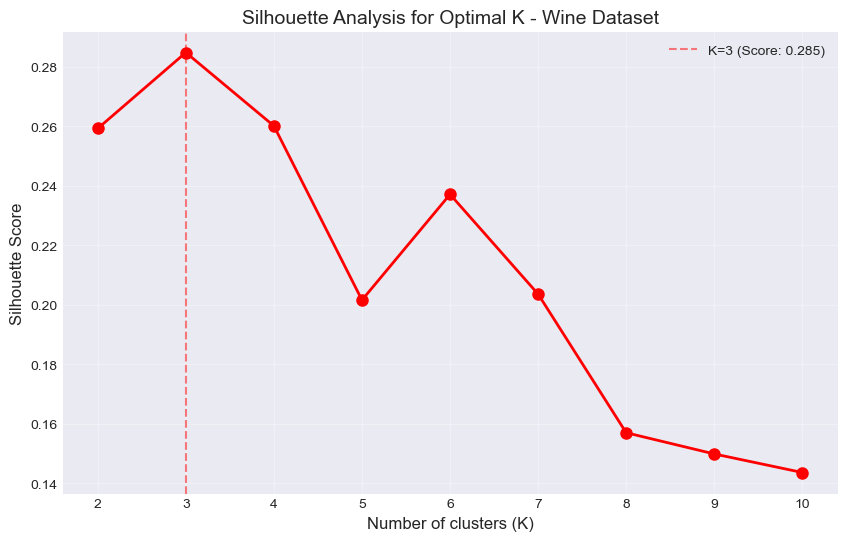

Silhouette Scores:
K=2: 0.2593
K=3: 0.2849
K=4: 0.2602
K=5: 0.2016
K=6: 0.2372
K=7: 0.2036
K=8: 0.1570
K=9: 0.1499
K=10: 0.1436


In [10]:
# Silhouette analysis
silhouette_scores = []
K_range_silhouette = range(2, 11)

for k in K_range_silhouette:
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=300, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(K_range_silhouette, silhouette_scores, 'ro-', linewidth=2, markersize=8)
plt.xlabel('Number of clusters (K)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title('Silhouette Analysis for Optimal K - Wine Dataset', fontsize=14)
plt.xticks(K_range_silhouette)
plt.grid(True, alpha=0.3)

# Mark K=3
k3_score = silhouette_scores[1]  # K=3 is at index 1
plt.axvline(x=3, color='r', linestyle='--', alpha=0.5, label=f'K=3 (Score: {k3_score:.3f})')
plt.legend()
plt.show()

# Print all scores
print("Silhouette Scores:")
for k, score in zip(K_range_silhouette, silhouette_scores):
    print(f"K={k}: {score:.4f}")

### Apply K-Means with K=3

In [11]:
# Apply K-Means with K=3
kmeans_3 = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=300, random_state=42)
y_pred = kmeans_3.fit_predict(X_scaled)

# Add cluster labels to the dataframe
wine_df['cluster'] = y_pred

print("Cluster distribution:")
print(pd.Series(y_pred).value_counts().sort_index())
print("\nTrue class distribution:")
print(pd.Series(y_true).value_counts().sort_index())

Cluster distribution:
0    65
1    51
2    62
Name: count, dtype: int64

True class distribution:
1    59
2    71
3    48
Name: count, dtype: int64


### Compare Clusters with True Wine Classes

Crosstab of True Classes vs K-Means Clusters:
cluster   0   1   2
Wine               
1         0   0  59
2        65   3   3
3         0  48   0

Note: The cluster labels (0,1,2) may not directly correspond to wine classes (1,2,3)


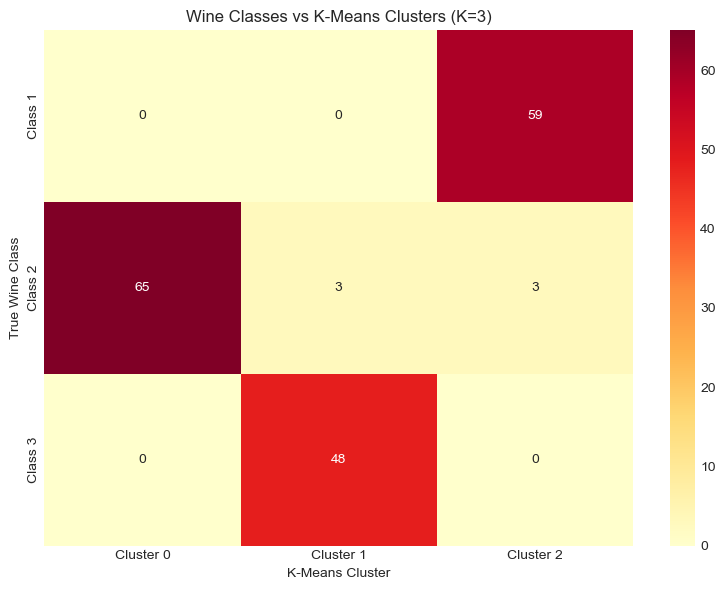

In [12]:
# Create a crosstab to compare clusters with true classes
ct = pd.crosstab(wine_df[class_column], wine_df['cluster'])
print("Crosstab of True Classes vs K-Means Clusters:")
print(ct)
print("\nNote: The cluster labels (0,1,2) may not directly correspond to wine classes (1,2,3)")

# Visualize the crosstab
plt.figure(figsize=(8, 6))
sns.heatmap(ct, annot=True, fmt='d', cmap='YlOrRd', cbar=True, 
            xticklabels=['Cluster 0', 'Cluster 1', 'Cluster 2'],
            yticklabels=['Class 1', 'Class 2', 'Class 3'])
plt.title('Wine Classes vs K-Means Clusters (K=3)')
plt.ylabel('True Wine Class')
plt.xlabel('K-Means Cluster')
plt.tight_layout()
plt.show()

In [13]:
# Calculate clustering performance metrics
ari = adjusted_rand_score(y_true, y_pred)
print(f"Adjusted Rand Index: {ari:.4f}")
print("(1.0 means perfect clustering, 0.0 means random clustering)")

# Calculate purity
def calculate_purity(y_true, y_pred):
    contingency_matrix = pd.crosstab(y_true, y_pred)
    return np.sum(np.amax(contingency_matrix.values, axis=0)) / np.sum(contingency_matrix.values)

purity = calculate_purity(wine_df[class_column], y_pred)
print(f"\nClustering Purity: {purity:.4f}")
print("(1.0 means perfect purity)")

# Calculate accuracy after best mapping
from scipy.optimize import linear_sum_assignment

def cluster_accuracy(y_true, y_pred):
    contingency_matrix = pd.crosstab(y_true, y_pred).values
    row_ind, col_ind = linear_sum_assignment(-contingency_matrix)
    return contingency_matrix[row_ind, col_ind].sum() / len(y_true)

accuracy = cluster_accuracy(y_true, y_pred)
print(f"\nBest mapping accuracy: {accuracy:.4f}")

Adjusted Rand Index: 0.8975
(1.0 means perfect clustering, 0.0 means random clustering)

Clustering Purity: 0.9663
(1.0 means perfect purity)

Best mapping accuracy: 0.9663


### Visualize Clustering Results

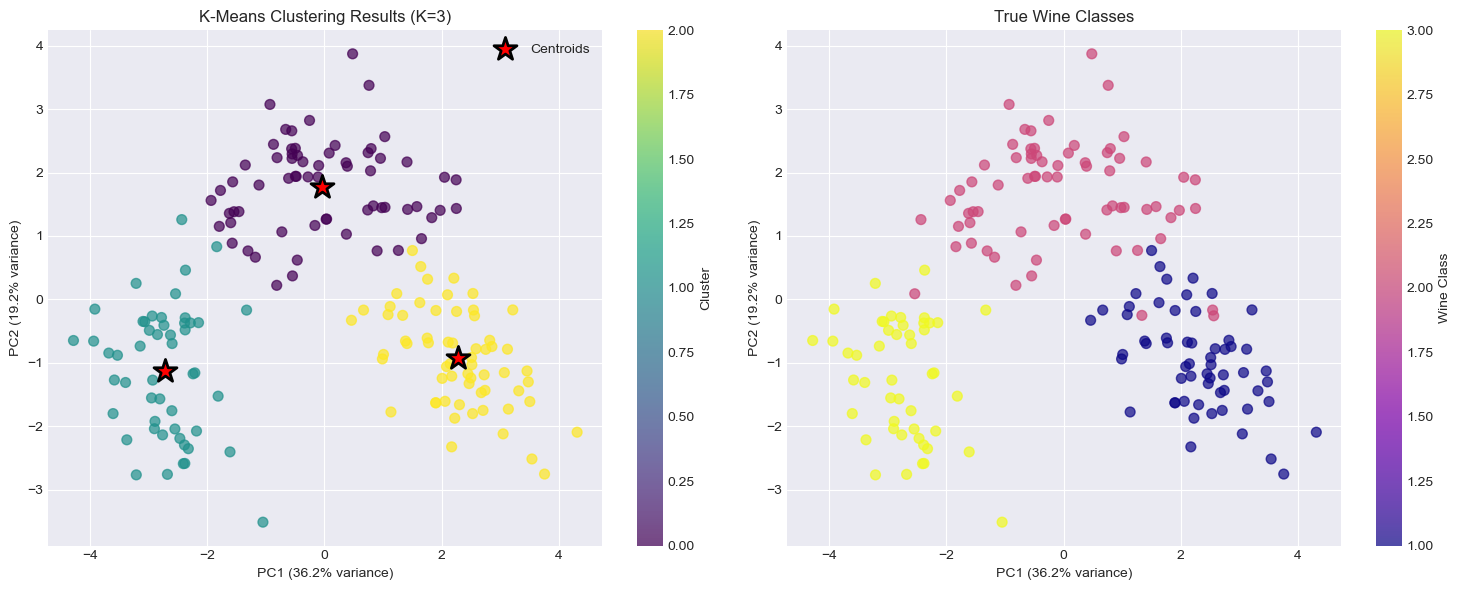

Total variance explained by first 2 PCs: 55.4%


In [14]:
# Use PCA for 2D visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Transform cluster centers
centers_pca = pca.transform(kmeans_3.cluster_centers_)

# Create figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: K-Means Clusters
scatter1 = ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred, cmap='viridis', s=50, alpha=0.7)
ax1.scatter(centers_pca[:, 0], centers_pca[:, 1], 
            c='red', marker='*', s=300, edgecolors='black', linewidth=2, label='Centroids')
ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
ax1.set_title('K-Means Clustering Results (K=3)')
ax1.legend()
plt.colorbar(scatter1, ax=ax1, label='Cluster')

# Plot 2: True Wine Classes
scatter2 = ax2.scatter(X_pca[:, 0], X_pca[:, 1], c=y_true, cmap='plasma', s=50, alpha=0.7)
ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
ax2.set_title('True Wine Classes')
plt.colorbar(scatter2, ax=ax2, label='Wine Class')

plt.tight_layout()
plt.show()

print(f"Total variance explained by first 2 PCs: {pca.explained_variance_ratio_.sum():.1%}")

### Analyze Cluster Characteristics

In [15]:
# Calculate mean values for each cluster
cluster_means = wine_df.groupby('cluster')[feature_names].mean()
print("Mean feature values for each cluster:")
print(cluster_means.round(2))

# Identify most distinguishing features
feature_variance = cluster_means.var()
top_features = feature_variance.nlargest(5).index.tolist()
print("\nTop 5 most distinguishing features (highest variance across clusters):")
for i, feature in enumerate(top_features, 1):
    print(f"{i}. {feature}: variance = {feature_variance[feature]:.2f}")

Mean feature values for each cluster:
         Alcohol  Malic.acid   Ash    Acl      Mg  Phenols  Flavanoids  \
cluster                                                                  
0          12.25        1.90  2.23  20.06   92.74     2.25        2.05   
1          13.13        3.31  2.42  21.24   98.67     1.68        0.82   
2          13.68        2.00  2.47  17.46  107.97     2.85        3.00   

         Nonflavanoid.phenols  Proanth  Color.int   Hue    OD  Proline  
cluster                                                                 
0                        0.36     1.62       2.97  1.06  2.80   510.17  
1                        0.45     1.15       7.23  0.69  1.70   619.06  
2                        0.29     1.92       5.45  1.07  3.16  1100.23  

Top 5 most distinguishing features (highest variance across clusters):
1. Proline: variance = 98590.90
2. Mg: variance = 58.93
3. Color.int: variance = 4.58
4. Acl: variance = 3.74
5. Flavanoids: variance = 1.20


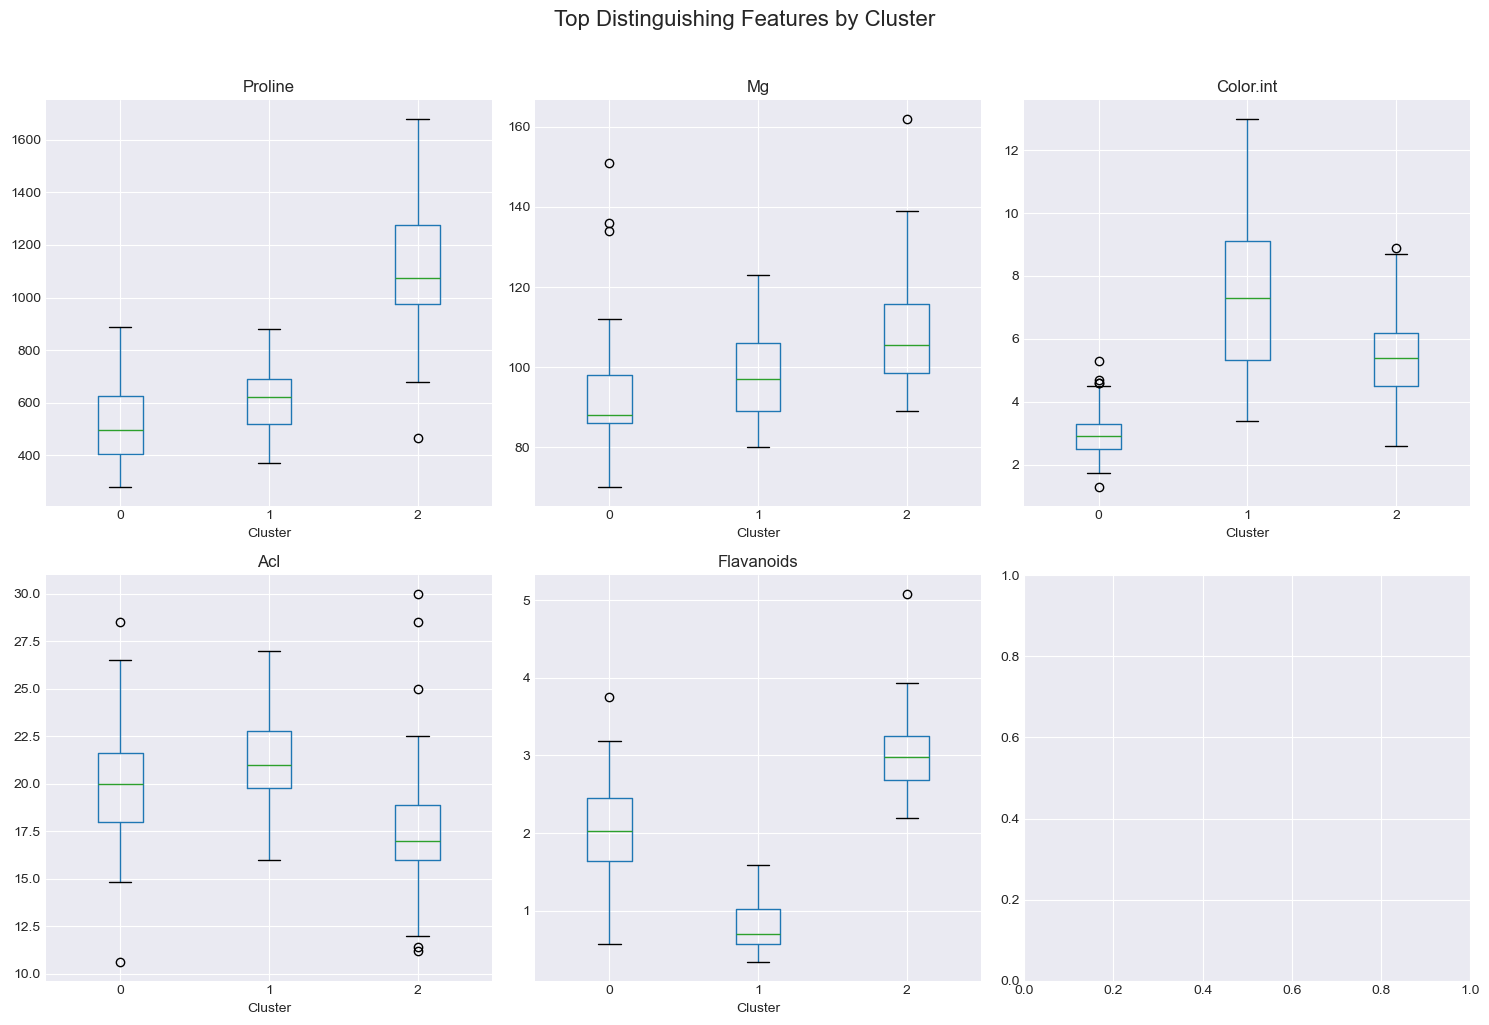

In [16]:
# Visualize top distinguishing features
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, feature in enumerate(top_features[:6]):
    wine_df.boxplot(column=feature, by='cluster', ax=axes[idx])
    axes[idx].set_title(f'{feature}')
    axes[idx].set_xlabel('Cluster')
    axes[idx].set_ylabel('')

plt.suptitle('Top Distinguishing Features by Cluster', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

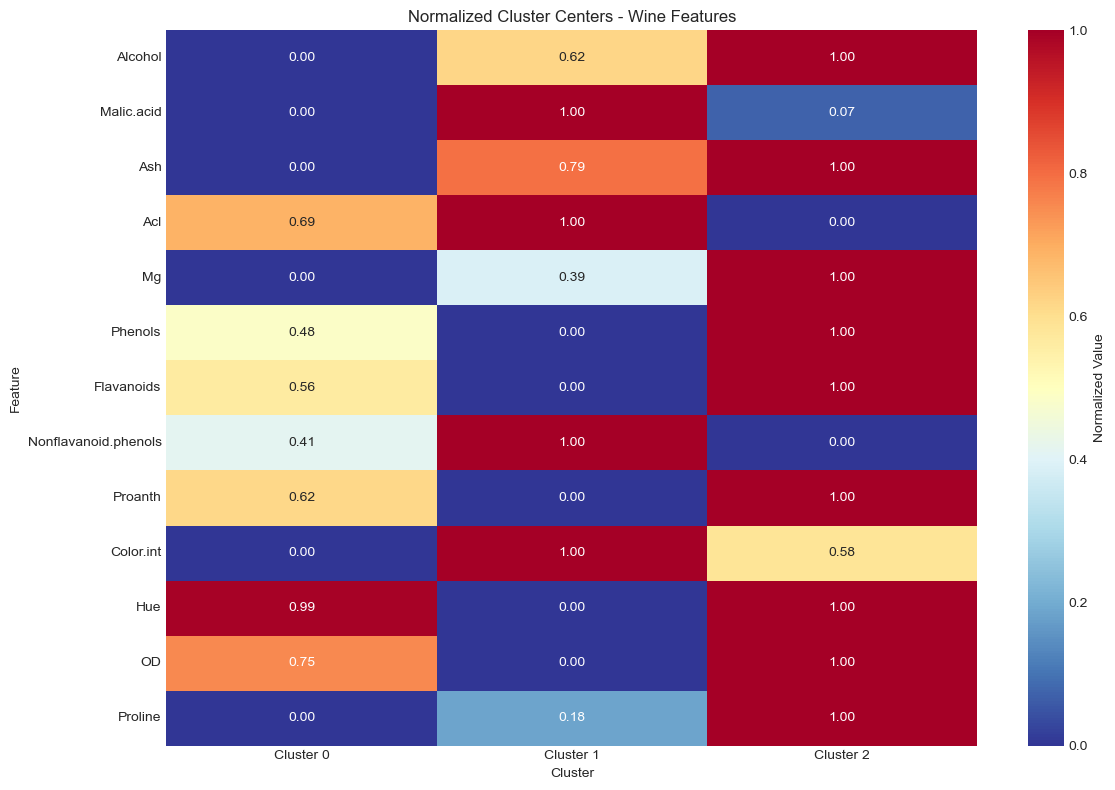

In [17]:
# Create a heatmap of normalized cluster centers
plt.figure(figsize=(12, 8))
cluster_centers_df = pd.DataFrame(
    scaler.inverse_transform(kmeans_3.cluster_centers_),
    columns=feature_names,
    index=[f'Cluster {i}' for i in range(3)]
)

# Normalize for visualization
cluster_centers_norm = (cluster_centers_df - cluster_centers_df.min()) / (cluster_centers_df.max() - cluster_centers_df.min())

sns.heatmap(cluster_centers_norm.T, cmap='RdYlBu_r', annot=True, fmt='.2f', 
            cbar_kws={'label': 'Normalized Value'})
plt.title('Normalized Cluster Centers - Wine Features')
plt.xlabel('Cluster')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

### Test Different Values of K

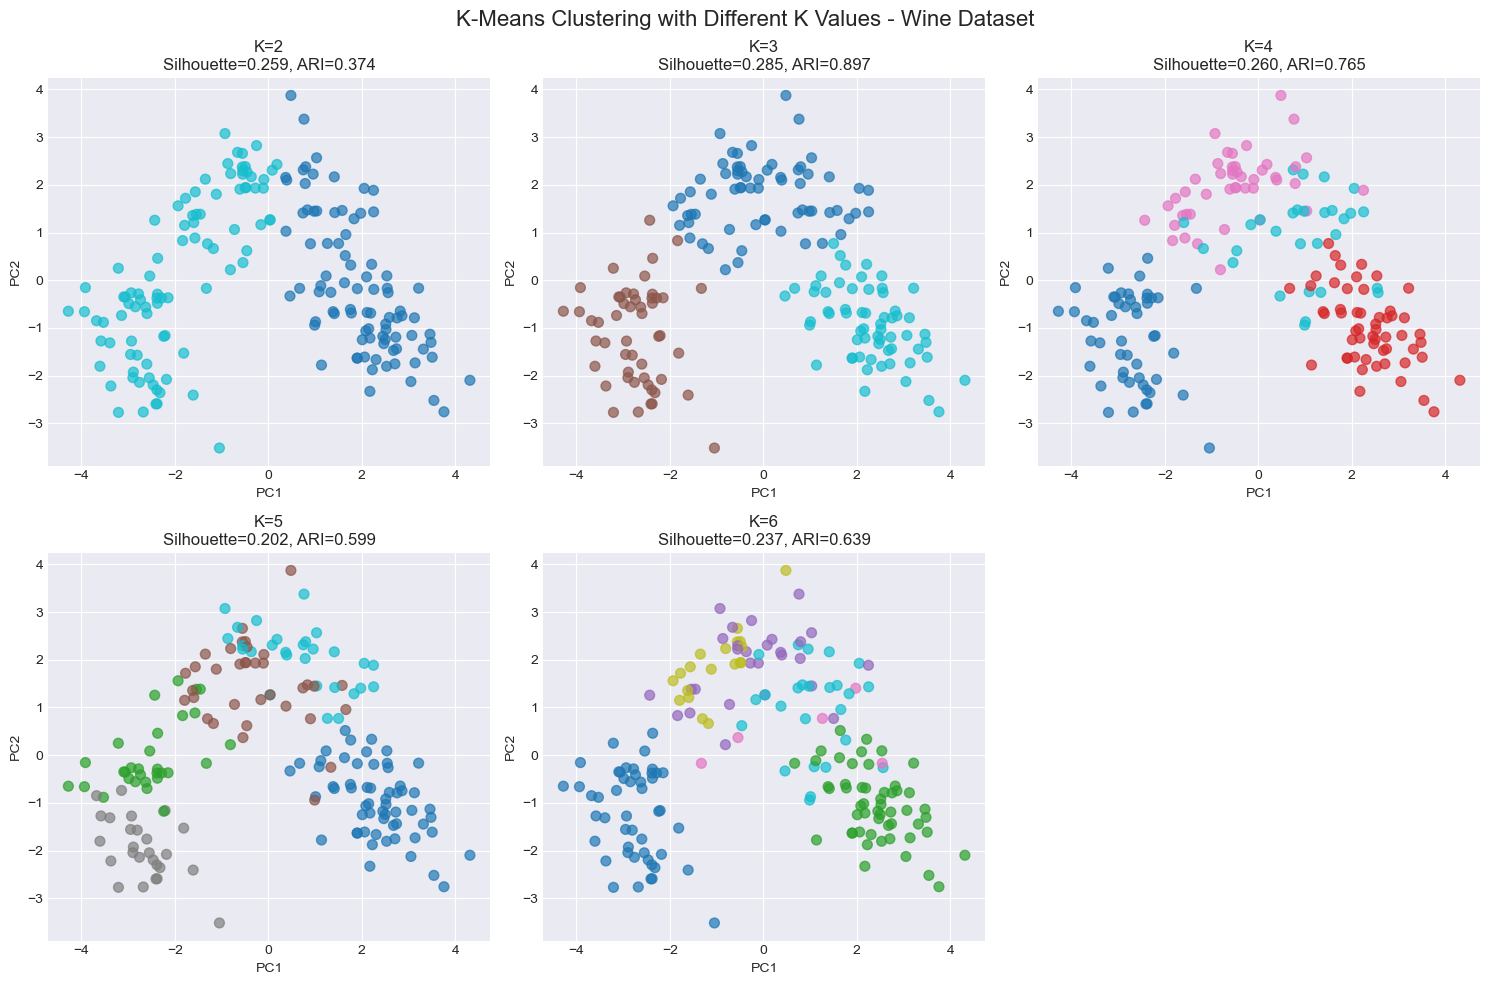


Clustering Results for Different K Values:
 K  Silhouette Score  Adjusted Rand Index         SSE
 2          0.259317             0.374314 1658.758852
 3          0.284859             0.897495 1277.928489
 4          0.260170             0.764564 1175.428333
 5          0.201619             0.599073 1109.512739
 6          0.237167             0.639098 1046.002333


In [18]:
# Test K values from 2 to 6
K_values = [2, 3, 4, 5, 6]
results = []

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, k in enumerate(K_values):
    # Apply K-Means
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    
    # Calculate metrics
    silhouette = silhouette_score(X_scaled, labels)
    ari = adjusted_rand_score(y_true, labels)
    
    results.append({
        'K': k,
        'Silhouette Score': silhouette,
        'Adjusted Rand Index': ari,
        'SSE': kmeans.inertia_
    })
    
    # Visualize
    scatter = axes[idx].scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='tab10', s=50, alpha=0.7)
    axes[idx].set_title(f'K={k}\nSilhouette={silhouette:.3f}, ARI={ari:.3f}')
    axes[idx].set_xlabel('PC1')
    axes[idx].set_ylabel('PC2')

# Remove extra subplot
fig.delaxes(axes[5])
plt.suptitle('K-Means Clustering with Different K Values - Wine Dataset', fontsize=16)
plt.tight_layout()
plt.show()

# Display results table
results_df = pd.DataFrame(results)
print("\nClustering Results for Different K Values:")
print(results_df.to_string(index=False))

### Compare with True Classes - Feature Analysis

In [19]:
# Compare cluster assignments with true classes
comparison_df = wine_df[[class_column, 'cluster'] + feature_names[:5]].copy()
print("Sample of cluster assignments vs true classes:")
print(comparison_df.head(10))

# Calculate mean features by true class
true_class_means = wine_df.groupby(class_column)[feature_names].mean()
print("\nMean feature values by TRUE wine class:")
print(true_class_means.round(2))

Sample of cluster assignments vs true classes:
   Wine  cluster  Alcohol  Malic.acid   Ash   Acl   Mg
0     1        2    14.23        1.71  2.43  15.6  127
1     1        2    13.20        1.78  2.14  11.2  100
2     1        2    13.16        2.36  2.67  18.6  101
3     1        2    14.37        1.95  2.50  16.8  113
4     1        2    13.24        2.59  2.87  21.0  118
5     1        2    14.20        1.76  2.45  15.2  112
6     1        2    14.39        1.87  2.45  14.6   96
7     1        2    14.06        2.15  2.61  17.6  121
8     1        2    14.83        1.64  2.17  14.0   97
9     1        2    13.86        1.35  2.27  16.0   98

Mean feature values by TRUE wine class:
      Alcohol  Malic.acid   Ash    Acl      Mg  Phenols  Flavanoids  \
Wine                                                                  
1       13.74        2.01  2.46  17.04  106.34     2.84        2.98   
2       12.28        1.93  2.24  20.24   94.55     2.26        2.08   
3       13.15        3.

In [ ]:
# Generate dynamic conclusions based on actual results
print("### Dynamic Conclusions Based on Your Results")
print("="*60)
print("\nBased on the K-Means clustering analysis of the Wine dataset:")

# 1. Optimal K analysis
print(f"\n1. **Optimal K Analysis**:")
if 'silhouette_scores' in locals() and len(silhouette_scores) > 0:
    best_k_idx = np.argmax(silhouette_scores)
    best_k = list(K_range_silhouette)[best_k_idx]
    best_silhouette = silhouette_scores[best_k_idx]
    print(f"   - Silhouette analysis suggests K={best_k} as optimal (score: {best_silhouette:.3f})")
    k3_idx = list(K_range_silhouette).index(3) if 3 in K_range_silhouette else None
    if k3_idx is not None:
        k3_silhouette = silhouette_scores[k3_idx]
        print(f"   - K=3 (matching true classes) achieves silhouette score of {k3_silhouette:.3f}")

# 2. Performance with K=3
print(f"\n2. **Clustering Performance (K=3)**:")
if 'ari' in locals():
    print(f"   - Adjusted Rand Index: {ari:.3f}")
    if ari > 0.8:
        quality = "excellent"
    elif ari > 0.6:
        quality = "very good"
    elif ari > 0.4:
        quality = "good"
    else:
        quality = "moderate"
    print(f"   - This indicates {quality} alignment with true wine classes")
    
if 'purity' in locals():
    print(f"   - Clustering Purity: {purity:.3f} ({purity*100:.1f}% correctly clustered)")
    
if 'accuracy' in locals():
    print(f"   - Best mapping accuracy: {accuracy:.3f}")
    print(f"   - This means {accuracy*100:.1f}% of wines are in their correct cluster")

# 3. Class/Cluster analysis
print(f"\n3. **Wine Class Separation**:")
if 'ct' in locals():
    # Find which wine classes are best separated
    for wine_class in ct.index:
        row = ct.loc[wine_class]
        dominant_cluster = row.idxmax()
        dominance = row[dominant_cluster] / row.sum()
        misclassified = row.sum() - row[dominant_cluster]
        print(f"   - Wine Class {wine_class}: {dominance:.1%} in cluster {dominant_cluster} ({misclassified} misclassified)")

# 4. Chemical composition analysis
print(f"\n4. **Chemical Composition Patterns**:")
if 'feature_variance' in locals() and 'top_features' in locals():
    print(f"   - Most distinguishing features:")
    for i, feature in enumerate(top_features[:3], 1):
        print(f"     {i}. {feature} (variance: {feature_variance[feature]:.2f})")
    
    # Special note about Proline
    if 'Proline' in top_features[:3]:
        print(f"   - Proline shows exceptional variance ({feature_variance['Proline']:.0f}), indicating")
        print(f"     it's a key discriminator between wine types")

# 5. Cluster characteristics
print(f"\n5. **Cluster Profiles**:")
if 'cluster_means' in locals():
    for cluster in range(3):
        cluster_data = cluster_means.loc[cluster]
        # Identify key characteristics
        high_features = []
        low_features = []
        
        for feature in feature_names:
            if feature in cluster_data.index:
                value = cluster_data[feature]
                overall_mean = wine_df[feature].mean()
                if value > overall_mean * 1.1:  # 10% above mean
                    high_features.append(feature)
                elif value < overall_mean * 0.9:  # 10% below mean
                    low_features.append(feature)
        
        print(f"   - Cluster {cluster}: ", end="")
        if high_features:
            print(f"High in {', '.join(high_features[:3])}", end="")
        if low_features:
            print(f", Low in {', '.join(low_features[:3])}", end="")
        print()

# 6. PCA insights
if 'pca' in locals():
    print(f"\n6. **Dimensionality Reduction**:")
    total_var = pca.explained_variance_ratio_.sum()
    print(f"   - First 2 PCs capture {total_var:.1%} of total variance")
    print(f"   - {'Good' if total_var > 0.5 else 'Limited'} cluster separation visible in 2D projection")

# 7. Comparison across different K
print(f"\n7. **Performance Across Different K Values**:")
if 'results_df' in locals():
    best_k_overall = results_df.loc[results_df['Silhouette Score'].idxmax(), 'K']
    best_ari_k = results_df.loc[results_df['Adjusted Rand Index'].idxmax(), 'K']
    print(f"   - Best silhouette score: K={best_k_overall}")
    print(f"   - Best ARI (matching true classes): K={best_ari_k}")
    if best_ari_k == 3:
        print(f"   - K=3 provides optimal match with true wine classes")

# 8. Overall assessment
print(f"\n8. **Overall Assessment**:")
if 'ari' in locals() and ari > 0.8:
    print("   - K-Means performs exceptionally well on this dataset")
    print("   - The algorithm successfully identifies wine types based on chemical composition")
    print("   - Chemical profiles are sufficiently distinct for accurate classification")
else:
    print("   - K-Means provides good separation of wine types")
    print("   - Some overlap exists between wine classes with similar chemical profiles")
    
print("\n9. **Practical Applications**:")
print("   - Wine quality control and verification")
print("   - Detecting wine fraud or mislabeling")
print("   - Understanding chemical signatures of different wine varieties")